<a href="https://colab.research.google.com/github/Patle1234/SpamFilter/blob/main/Spam_Filter_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import
Here we import all of our libraries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
import nltk
nltk.download('wordnet')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk import PorterStemmer
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Model
We are using a Logistic Regression Model




In [ ]:
class LogisticRegression(nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        
        self.linear1 = nn.Linear(10000,100)
        self.linear2 = nn.Linear(100,10)
        self.linear3 = nn.Linear(10,2)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x


# Import Dataset
We are using a CSV file as out dataset. There are two rows, one for the email, and one for the classification(emial or not)

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
  
data=pd.read_csv('/content/emails.csv')


Saving emails.csv to emails.csv
User uploaded file "emails.csv" with length 8954755 bytes


# Stop Words
We remove the stop words


In [ ]:
remove_non_alphabets =lambda x: re.sub(r'[^a-zA-Z]',' ',x)
data['text'] = data['text'].apply(remove_non_alphabets)
print(data.head())

                                                text  spam
0  Subject  naturally irresistible your corporate...     1
1  Subject  the stock trading gunslinger  fanny i...     1
2  Subject  unbelievable new homes made easy  im ...     1
3  Subject    color printing special  request add...     1
4  Subject  do not have money   get software cds ...     1


# Tokenization
Here we are doing our tokenization

In [ ]:
tokenize=lambda x: word_tokenize(x)
data['text'] = data['text'].apply(tokenize)
print(data.head())

                                                text  spam
0  [Subject, naturally, irresistible, your, corpo...     1
1  [Subject, the, stock, trading, gunslinger, fan...     1
2  [Subject, unbelievable, new, homes, made, easy...     1
3  [Subject, color, printing, special, request, a...     1
4  [Subject, do, not, have, money, get, software,...     1


## Stemming
Here is where we stem our email

In [ ]:
ps = PorterStemmer()
stem = lambda w: [ ps.stem(x) for x in w ]
data['text'] = data['text'].apply(stem)
print(data.head())


                                                text  spam
0  [subject, natur, irresist, your, corpor, ident...     1
1  [subject, the, stock, trade, gunsling, fanni, ...     1
2  [subject, unbeliev, new, home, made, easi, im,...     1
3  [subject, color, print, special, request, addi...     1
4  [subject, do, not, have, money, get, softwar, ...     1


#Lemmatization
Here we apply lemmatization


In [ ]:

lemmatizer = WordNetLemmatizer()
leammtizer = lambda x: [ lemmatizer.lemmatize(word) for word in x ]
data['text'] = data['text'].apply(leammtizer)
data['text'] = data['text'].apply(lambda x: ' '.join(x))
print(data.head())


                                                text  spam
0  subject natur irresist your corpor ident lt is...     1
1  subject the stock trade gunsling fanni is merr...     1
2  subject unbeliev new home made easi im want to...     1
3  subject color print special request addit info...     1
4  subject do not have money get softwar cd from ...     1


#Split out dataset
Here we are splitting out dataset into two categories: 
> 
Training:This is what out model will use to train
> 
Testing:This is the data used to find how good out model is


In [ ]:
max_words = 10000
cv = CountVectorizer(max_features=max_words, stop_words='english')#bag of words
sparse_matrix = cv.fit_transform(data['text']).toarray()

print(sparse_matrix.shape)#prints the dimensions of the matrix


x_train, x_test, y_train, y_test = train_test_split(sparse_matrix, np.array(data['spam']))


(5728, 10000)


#Creating the Model
Here we are creating an instance of our Model. Then, we define our optimization function, learing rate, and loss.

In [ ]:
model = LogisticRegression()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters() , lr=0.01)

x_train = Variable(torch.from_numpy(x_train)).float()
y_train = Variable(torch.from_numpy(y_train)).long()
x_test = Variable(torch.from_numpy(x_test)).float()
y_test = Variable(torch.from_numpy(y_test)).long()


#Training+Testing Our Model
We are training through our datset 20 times(epochs). Then we go through the testing data to find our final accuracy


In [ ]:
epochs = 20
model.train()
loss_values = []
for epoch in range(epochs):
    optimizer.zero_grad()
    y_pred = model(x_train)
    loss = criterion(y_pred, y_train)
    loss_values.append(loss.item())
    pred = torch.max(y_pred, 1)[1].eq(y_train).sum()
    acc = pred * 100.0 / len(x_train)
    print('Epoch: {}, Loss: {}, Accuracy: {}%'.format(epoch+1, loss.item(), acc.numpy()))
    loss.backward()#gradient descent
    optimizer.step()


with torch.no_grad():
    y_pred = model(x_test)
    loss = criterion(y_pred, y_test)
    pred = torch.max(y_pred, 1)[1].eq(y_test).sum()
    print ("Accuracy : {}%".format(100*pred/len(x_test))) 

Epoch: 1, Loss: 0.6168839335441589, Accuracy: 75.8845443725586%
Epoch: 2, Loss: 0.4054396152496338, Accuracy: 76.09403991699219%
Epoch: 3, Loss: 0.27820178866386414, Accuracy: 77.28118896484375%
Epoch: 4, Loss: 0.2174481451511383, Accuracy: 83.40316772460938%
Epoch: 5, Loss: 0.16155879199504852, Accuracy: 90.29329681396484%
Epoch: 6, Loss: 0.11283919215202332, Accuracy: 95.11173248291016%
Epoch: 7, Loss: 0.07596375793218613, Accuracy: 98.53351593017578%
Epoch: 8, Loss: 0.05003871023654938, Accuracy: 99.23184204101562%
Epoch: 9, Loss: 0.0322624146938324, Accuracy: 99.55773162841797%
Epoch: 10, Loss: 0.02054760232567787, Accuracy: 99.7905044555664%
Epoch: 11, Loss: 0.013137455098330975, Accuracy: 99.81378173828125%
Epoch: 12, Loss: 0.008545655757188797, Accuracy: 99.86033630371094%
Epoch: 13, Loss: 0.005712979007512331, Accuracy: 99.93016815185547%
Epoch: 14, Loss: 0.004063830245286226, Accuracy: 99.93016815185547%
Epoch: 15, Loss: 0.0030463070143014193, Accuracy: 99.93016815185547%
Epoc

#Graph Our Model
Here we graph the loss of our model. Loss is how well our model did(higher the loss, the better the model)

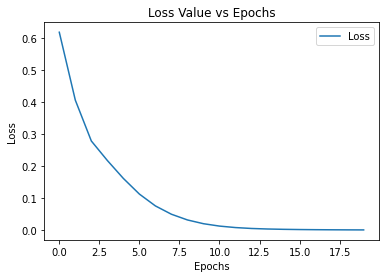

In [ ]:
plt.plot(loss_values)
plt.title('Loss Value vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Loss'])
plt.show()


#Have fun with your model!
You can put in your own email in the email varible. The closer the output is to 1 it spam


In [ ]:
import io
import csv
data_string = """name:email
                 email:hello how are you
"""
data = io.StringIO(data_string)
email = pd.read_csv(data, sep=":")

remove_non_alphabets =lambda x: re.sub(r'[^a-zA-Z]',' ',x)
tokenize=lambda x: word_tokenize(x)
ps = PorterStemmer()
stem = lambda w: [ ps.stem(x) for x in w ]
lemmatizer = WordNetLemmatizer()
leammtizer = lambda x: [ lemmatizer.lemmatize(word) for word in x ]

email['email'] = email['email'].apply(remove_non_alphabets)
email['email'] = email['email'].apply(tokenize)
email['email'] = email['email'].apply(stem)
email['email'] = email['email'].apply(leammtizer)
email['email'] = email['email'].apply(lambda x: ' '.join(x))
print("hello: ",email.head)

max_words = 10000
cv = CountVectorizer(max_features=max_words, stop_words='english')
sparse_matrix = cv.fit_transform(email['email']).toarray()

N = 10000-1
x=np.pad(sparse_matrix, (0, N), 'constant')
print("xsize : ",x.shape)

x_play = Variable(torch.from_numpy(x)).float()
pred=model(x_play)

print("predict: ",pred)


hello:  <bound method NDFrame.head of                      name              email
0                   email  hello how are you>
xsize :  (10000, 10000)
predict:  tensor([[ 1.1524, -1.2679],
        [ 0.5360, -0.4272],
        [ 0.5360, -0.4272],
        ...,
        [ 0.5360, -0.4272],
        [ 0.5360, -0.4272],
        [ 0.5360, -0.4272]], grad_fn=<AddmmBackward>)
